In [1]:
import numpy as np
import matplotlib.pyplot as plt
import html

from ase.io import read, Trajectory
from ase.data import covalent_radii
from ase.geometry import get_distances

In [2]:

def make_bond_dic(poscar, mol_index, bl_limit=0.5):
    bond_sub_dic = {}
    for i in mol_index:
        bond_list = []
        for j in range(len(poscar)):
            if j not in mol_index:
                cov_i = covalent_radii[poscar[i].number]
                cov_j = covalent_radii[poscar[j].number]
                bond_limit = cov_i + cov_j + bl_limit
                distance = abs(get_distances(poscar.get_positions()[i],
                                             poscar.get_positions()[j])[1])
                if distance <= bond_limit:
                    bond_list += [poscar[j].symbol]
        bond_sub_dic[f'{i}-{poscar[i].symbol}'] = bond_list

    return bond_sub_dic
    

def filter_out(reference, structure, flexibility):
    """
    This function is used to determine whether 
    the candidate structure has the same shape as the reference structure.
    """
    ref_pos = reference.get_positions()
    str_pos = structure.get_positions()
    
    same = True
    for i in range(len(ref_pos)):
        distance = np.linalg.norm(ref_pos[i]-str_pos[i])
        if distance > 0.05 + flexibility:
            same = False
            break
            
    return same


def candidate_filter(structures,
                     stoichiometry=0,
                     energy_gap=None,
                     flexibility=1.0):
    """
    This function is used to filter out similar candidates 
    
    structures: list of ase.Atoms objects
    """ 
    strucs = structures
    ene = np.array([atoms.get_potential_energy() for atoms in strucs])
    min_ene = np.min(ene)
    
    sorted_ene_indices = np.argsort(ene)
    candidates_list = [sorted_ene_indices[0]]
    ref = strucs[candidates_list[0]]
    out_of_range = False

    for i in range(len(strucs)):
        similar = filter_out(reference=ref[-stoichiometry:],
                             structure=strucs[sorted_ene_indices[i]][-stoichiometry:],
                             flexibility=flexibility)
        if not similar:
            candidates_list += [sorted_ene_indices[i]]
            c_ls = candidates_list.copy()
            del c_ls[-1]
            for j in c_ls:
                similar = filter_out(reference=strucs[sorted_ene_indices[i]][-stoichiometry:],
                                     structure=strucs[j][-stoichiometry:],
                                     flexibility=flexibility)
                if energy_gap != None:
                    ene_limit = energy_gap + min_ene
                    if ene[sorted_ene_indices[i]] > ene_limit:
                        out_of_range = True
                        
                if similar or out_of_range:
                    del candidates_list[-1]
                    break
                    
            if out_of_range:
                break
    
    return candidates_list

    
def get_energy_and_xy_coords(structures, mol_index, candidates_list):
    ene = []
    ene_au = []
    ene_sto = []
    ene_au_and_sto = []
    x_y = []
    for i in candidates_list:
        atoms = structures[i]
        bond_sub_dic = make_bond_dic(atoms, mol_index, bl_limit=0.7)
        values = [element for sublist in bond_sub_dic.values() for element in sublist]
        if len(values) != 0:
            ene.append(atoms.get_potential_energy())
            pos = list(atoms.get_positions()[mol_index[0]][:2])
            x_y.append(pos)
            
            if 'Au' in values:
                if 'Sr' in values or 'Ti' in values or 'O' in values:
                    ene_au_and_sto.append(atoms.get_potential_energy())
                else:
                    ene_au.append(atoms.get_potential_energy())
            else:
                ene_sto.append(atoms.get_potential_energy())
                
    return np.array(ene), np.array(ene_au), np.array(ene_sto), np.array(ene_au_and_sto), np.array(x_y)



In [3]:
data_path = "../../Data/ML_global_optimization/CO_adsorption_site_sampling"
mol_index = [170, 171]  # C:170, O:171

ene = []
ene_au = []
ene_sto = []
ene_au_and_sto = []
x_y = []

for i in range(10):
    file_path = f'{data_path}/global_sampling-{i+1}/structures.traj'
    traj = Trajectory(file_path)
    candidates_list = candidate_filter(structures=traj,
                                       stoichiometry=2,
                                       energy_gap=2.5)
    _ene, _ene_au, _ene_sto, _ene_au_and_sto, _x_y = get_energy_and_xy_coords(traj, 
                                                                              mol_index, 
                                                                              candidates_list)
    if len(x_y) == 0:
        x_y = _x_y
    else:
        x_y = np.vstack((x_y, _x_y))
    ene = np.concatenate((ene, _ene), axis=0)
    ene_au = np.concatenate((ene_au, _ene_au), axis=0)
    ene_sto = np.concatenate((ene_sto, _ene_sto), axis=0)
    ene_au_and_sto = np.concatenate((ene_au_and_sto, _ene_au_and_sto), axis=0)
    traj.close()


## Binding energy histogram

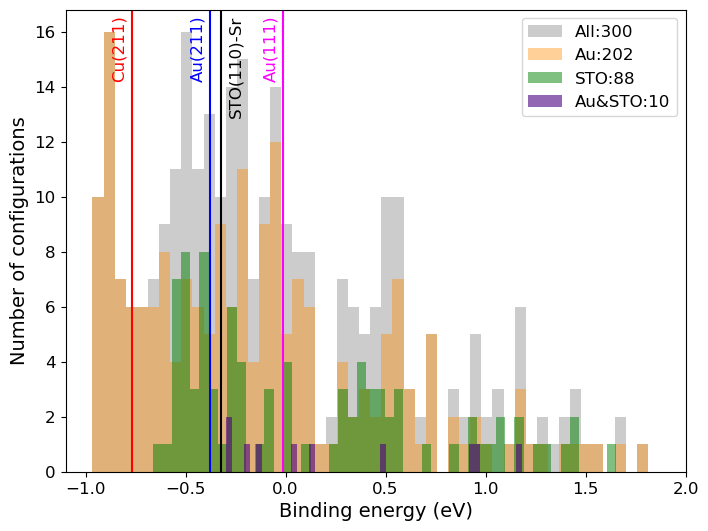

In [4]:
## Binding energy = E_slab+ads - (E_slab + E_ads)
ref_ene = (-611.56785654) + (-12.06594570)  # E_slab + E_ads

plt.figure(figsize=(8, 6))
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.hist(ene - ref_ene, color='black', alpha=0.2, bins=50, label=f'All:{len(ene)}')
plt.hist(ene_au - ref_ene, color='darkorange', alpha=0.4, bins=50, label=f'Au:{len(ene_au)}')
plt.hist(ene_sto - ref_ene, color='green', alpha=0.5, bins=50, label=f'STO:{len(ene_sto)}')
plt.hist(ene_au_and_sto - ref_ene, color='indigo', alpha=0.6, bins=50, label=f'Au&STO:{len(ene_au_and_sto)}')

h = 14.3
angle = 90
adj = 0.1
plt.axvline(x=-0.767334, color='red')  
plt.text(-0.767334-adj,  h-0.01, 'Cu(211)', rotation=angle, color='red', fontsize=12)

plt.axvline(x=-0.3771371, color='blue')
plt.text(-0.3771371-adj, h, 'Au(211)', rotation=angle, color='blue', fontsize=12)

plt.axvline(x=-0.011049, color='magenta')
plt.text(-0.011049-adj, h, 'Au(111)', rotation=angle, color='magenta', fontsize=12)

plt.axvline(x=-0.324154, color='black')
plt.text(-0.324154+adj/2-0.01, h-1.3, 'STO(110)-Sr', rotation=angle, color='black', fontsize=12)

plt.xlabel('Binding energy (eV)', fontsize=14)
plt.ylabel('Number of configurations', fontsize=14)
plt.xlim(-1.1, 2.0)
plt.legend(fontsize=12)
plt.show()


## Binding energy scatter plot

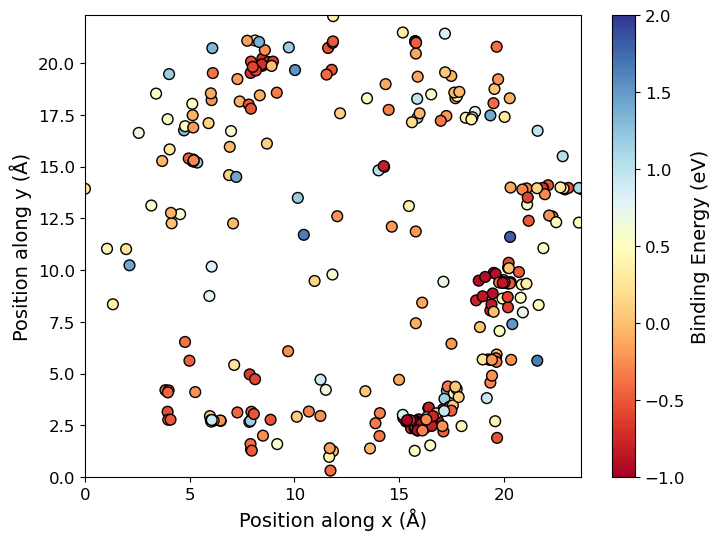

In [5]:
#cmap = plt.cm.get_cmap('RdYlBu')
cmap = plt.cm.RdYlBu

x = x_y[:,0]
y = x_y[:,1]

# scatter plot
plt.figure(figsize=(8,6))
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 

a = read('POSCAR-Au50STO')
cell = a.get_cell().copy()

plt.scatter(x, y, s=60, c=ene-ref_ene, cmap=cmap, vmin=-1, vmax=2, marker='o', edgecolor='black')
plt.xlabel(f'Position along x ({html.unescape("&Aring;")})', fontsize=14)
plt.ylabel(f'Position along y ({html.unescape("&Aring;")})', fontsize=14)
plt.colorbar().set_label('Binding Energy (eV)', fontsize=14) 
plt.xlim(0, cell[0][0])
plt.ylim(0, cell[1][1])
plt.show()
